In [2]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy as np 
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt 

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [3]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = np.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = np.array(snapshot.particles.orientation)
    angles = 2 * np.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [4]:
m = 5
N_particles = m**2
spacing = 10
K = math.ceil(N_particles ** (1 / 2))
L = K * spacing 
x = np.linspace(-L / 2, L / 2, K, endpoint=False)
position = [(px, py, 0) for px, py in itertools.product(x, x)][:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

# Create GSD snapshot
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position
frame.particles.orientation = orientation
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, 0, 0, 0, 0]
frame.particles.types = ['Hat_Tile']


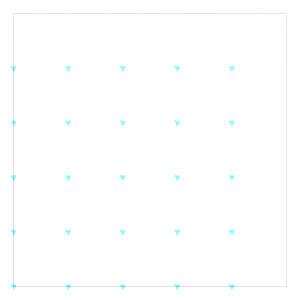

In [5]:
render(frame)

In [6]:
fn = os.path.join(os.getcwd(), '25_tile_lattice.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='25_tile_lattice.gsd', mode='x') as f:
    f.append(frame)

In [7]:
def area():
    vertices = [
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
    n = len(vertices)
    area = 0.5 * abs(sum(vertices[i][0] * vertices[(i + 1) % n][1] - vertices[i][1] * vertices[(i + 1) % n][0] for i in range(n)))
    return area

area = area()
area

0.592948717948718

In [86]:
cpu = hoomd.device.CPU()

In [87]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='25_tile_lattice.gsd')

In [88]:
fn = os.path.join(os.getcwd(), 'trajectory_cmp.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [89]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.005929487179487179, 2500.0)

In [90]:
betaP = 1
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

volume_fractions_1 = []
pressures = []
timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions_1.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()
    


Pressure = 1, Volume Fraction = 0.005929487179487179
Pressure 1: Overlaps = 0, Volume Fraction = 0.23289260269756626


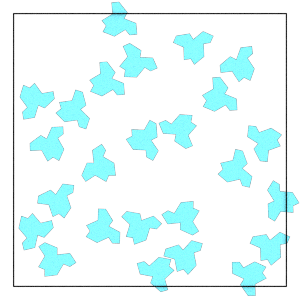

In [91]:
render(simulation.state.get_snapshot())

In [92]:
simulation.timestep

100000

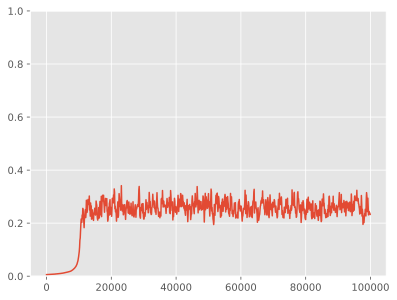

In [93]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions_1)

In [94]:
mc.overlaps

0

In [95]:
vf = np.mean(volume_fractions_1[len(volume_fractions_1)//2:])
vf

np.float64(0.258701900719521)

In [96]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='trajectory_cmp.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp5.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp5.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [97]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.23289261604748532, 63.65044199467229)

In [98]:
betaP = 5
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

volume_fractions_5 = []
pressures = []
timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions_5.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()
    


Pressure = 5, Volume Fraction = 0.23289261604748532
Pressure 5: Overlaps = 0, Volume Fraction = 0.47253425378015146


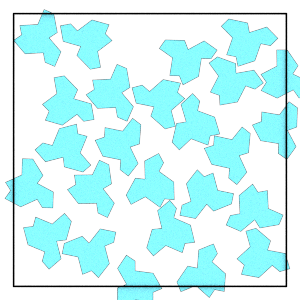

In [99]:
render(simulation.state.get_snapshot())

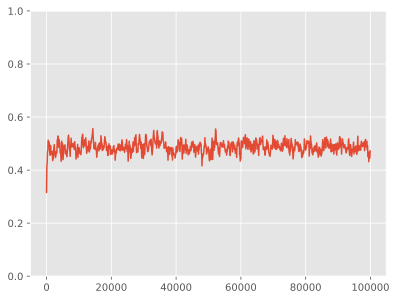

In [100]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions_5)

In [101]:
vf = np.mean(volume_fractions_5[len(volume_fractions_5)//2:])
vf

np.float64(0.48769427310198216)

In [102]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='trajectory_cmp5.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp10.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp10.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [103]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.47253422633077485, 31.37067565205598)

In [104]:
betaP = 10
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

volume_fractions_10 = []
pressures = []
timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions_10.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 10, Volume Fraction = 0.47253422633077485
Pressure 10: Overlaps = 0, Volume Fraction = 0.5927280406112606


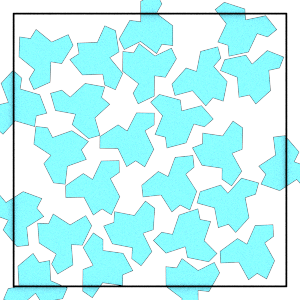

In [105]:
render(simulation.state.get_snapshot())

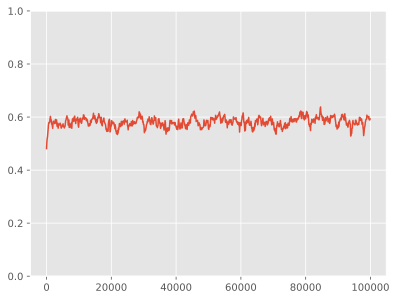

In [106]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions_10)

In [107]:
vf = np.mean(volume_fractions_10[len(volume_fractions_10)//2:])
vf

np.float64(0.5841019001292211)

In [108]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='trajectory_cmp10.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp20.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp20.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [109]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.5927280162008135, 25.00930872769095)

In [110]:
betaP = 20
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

volume_fractions_20 = []
pressures = []
timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions_20.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 20, Volume Fraction = 0.5927280162008135
Pressure 20: Overlaps = 0, Volume Fraction = 0.6647525460855485


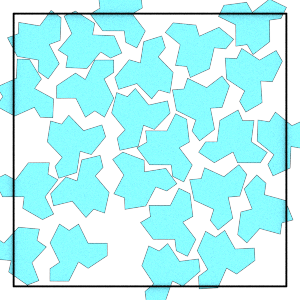

In [111]:
render(simulation.state.get_snapshot())

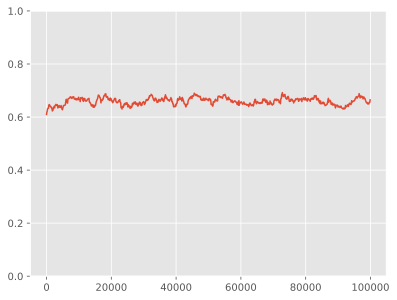

In [112]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions_20)

In [113]:
vf = np.mean(volume_fractions_20[len(volume_fractions_20)//2:])
vf

np.float64(0.6596464436289781)

In [126]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='trajectory_cmp20.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp40.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp40.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [127]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.6647525082262469, 22.29960438701005)

In [128]:
betaP = 40
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

volume_fractions_30 = []
pressures = []
timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions_30.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 40, Volume Fraction = 0.6647525082262469
Pressure 40: Overlaps = 0, Volume Fraction = 0.7229164072303365


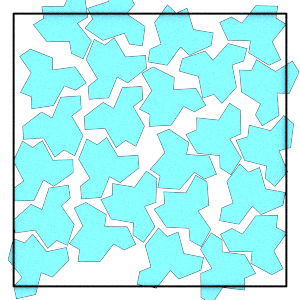

In [129]:
render(simulation.state.get_snapshot())

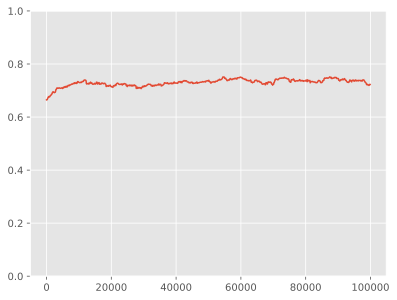

In [130]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions_30)

In [131]:
vf = np.mean(volume_fractions_30[len(volume_fractions_30)//2:])
vf

np.float64(0.738097277076137)

In [132]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='trajectory_cmp40.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp60.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp60.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [133]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.722916401262857, 20.50543869640046)

In [134]:
betaP = 60
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

volume_fractions_30 = []
pressures = []
timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions_30.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 60, Volume Fraction = 0.722916401262857
Pressure 60: Overlaps = 0, Volume Fraction = 0.7571957150256391


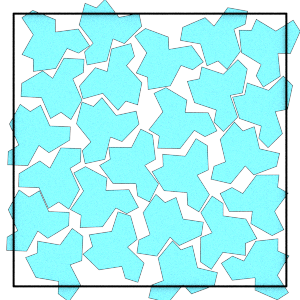

In [135]:
render(simulation.state.get_snapshot())

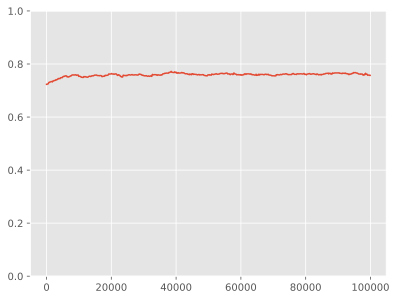

In [136]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions_30)

In [137]:
vf = np.mean(volume_fractions_30[len(volume_fractions_30)//2:])
vf

np.float64(0.7617977155150847)

In [161]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='trajectory_cmp600.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp1200.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp1200.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [162]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.7963979123287407, 18.613456563907903)

In [163]:
betaP = 1200
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

volume_fractions_30 = []
pressures = []
timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions_30.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 1200, Volume Fraction = 0.7963979123287407
Pressure 1200: Overlaps = 0, Volume Fraction = 0.7980920611860196


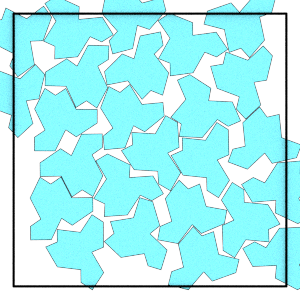

In [164]:
render(simulation.state.get_snapshot())

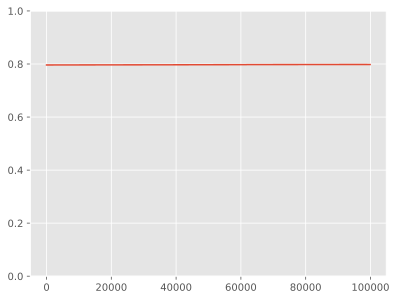

In [165]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions_30)

In [168]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='trajectory_cmp1200.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp_fin.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp_fin.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [169]:
mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

In [171]:
simulation.run(10e5)

In [173]:
simulation.timestep

2100000

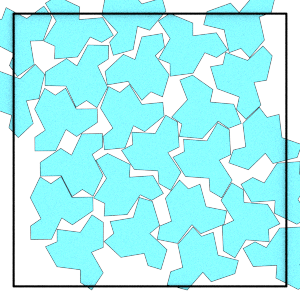

In [174]:
render(simulation.state.get_snapshot())

In [175]:
mc.overlaps

0

In [176]:
gsd_writer.flush()